# Rayleigh-Benard convection

Learn normal form for onset of rolls

In [1]:
import numpy as np
import numpy.random as rng

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from scipy import linalg
import scipy.io as sio
from scipy.integrate import solve_ivp

# To reproduce results for plots, etc
seed = np.random.randint(low=0, high=2**32-1)
seed = 1062360483
print(seed)
rng = np.random.RandomState(seed)

import sympy as sym

1062360483


### Nullspace search

In [2]:
from itertools import compress, product, combinations

from math import isnan, isinf

# Very inefficient
def is_collinear(v1, v2):
    # Return True if v1 and v2 are collinear vectors
    r = v1/v2
    x = []
    for i, ri in enumerate(r):
        if np.isfinite(ri) and abs(ri) > 0:
            x.append(ri)
    if len(x)>0 and not np.any(np.array(x)-x[0]):
        return True
    else:
        return False

def number_exists(num, nondim):
    # Return True if num (or a collinear to it) already exists in list 
    if not np.any(num):
        return True
    # Ignore collinearity here to avoid having to define more "p_fns"
    """for discovered in nondim:
        if is_collinear(num, discovered):
            return True"""
    return False


def get_nondim_numbers(dim_matrix, degree, num_params, time_vec=None):
    """
    Returns all possible dimensionless numbers in nullspace up to degree.
    
    If time_vec is included, should give the dimensions of time in dim_matrix rows
        e.g. [0, 0, 1]
        In this case, also returns all possible timescales
    """
    all_combinations = np.array(list(product(*[range(-degree, degree+1)] * num_params)))
    idxsort = np.argsort(np.sum(np.abs(all_combinations), axis=1))
    all_combinations = all_combinations[idxsort]
    nondim_list = []
    timescale_list = []
    for i in range(all_combinations.shape[0]):
        pi_candidate = all_combinations[i, :]
        if not np.any(dim_matrix @ pi_candidate):
            if not number_exists(pi_candidate, nondim_list):
                nondim_list.append(pi_candidate)
        elif (time_vec is not None) and (not np.any( dim_matrix @ pi_candidate - time_vec )):
            if not number_exists(pi_candidate, timescale_list):
                timescale_list.append(pi_candidate)
    return nondim_list, timescale_list


## Sparse regression

In [3]:
class STLSQ():
    def __init__(self, threshold=0.0, cond=None, max_iter=10, normalize=False):
        self.threshold = threshold
        self.cond = cond
        self.max_iter = max_iter
        self.normalize = normalize
        
    def fit(self, lib, dy, row_weights=None):
        
        # Row weights control relative weighting of different parameters
        if row_weights is None:
            row_weights = np.ones(lib.shape[0])
            
        # Column weights to normalize features (candidate functions)
        col_weights = np.ones(lib.shape[1])
        if self.normalize:
            col_weights = 1 / np.max(abs(lib), axis=0)
            
        lib_w = ( lib * col_weights[None, :] ) * row_weights[:, None]
        lhs_w = dy * row_weights[:, None]
        
        # Initial least-squares guess
        Xi = linalg.lstsq(lib_w, lhs_w, cond=self.cond)[0] * col_weights[:, None]
        
        # Iterate and threshold
        for k in range(self.max_iter):
            for i in range(Xi.shape[1]):
                small_idx = (abs(Xi[:, i]) < self.threshold)  # Find small indices
                Xi[small_idx, i] = 0   # Threshold
                big_idx = np.logical_not( small_idx[:] )
                # Regress dynamics onto remaining terms to find sparse Xi
                Xi[big_idx, i]  = linalg.lstsq(lib_w[:, big_idx], lhs_w[:, i], cond=self.cond)[0] * col_weights[big_idx]
        self.coef_ = Xi.T

# Load dimensionless data

In [4]:
data = sio.loadmat('../data/RB_data.mat')
keys = [key for key in data.keys() if key[:2] != '__']

tau_list = []
CQ_list = []
Ra_list = []
Pr_list = []
for key in keys:
    tau_list.append( data[key]['t'][0][0].flatten() )
    CQ_list.append( abs( data[key]['Qhat'][0][0].flatten() ) )
    Ra_list.append( data[key]['Ra'][0][0][0, 0] )
    Pr_list.append( data[key]['Pr'][0][0][0, 0] )
    
dCQ_list = [np.gradient(CQ_list[idx], tau_list[idx][1]-tau_list[idx][0]) for idx in range(len(CQ_list))]

tau = np.array(tau_list)  # Note this assumes same simulation length (but this could be rewritten)
CQ = np.array(CQ_list)
Pr = np.array(Pr_list)
Ra = np.array(Ra_list)

### Plot dimensionless results

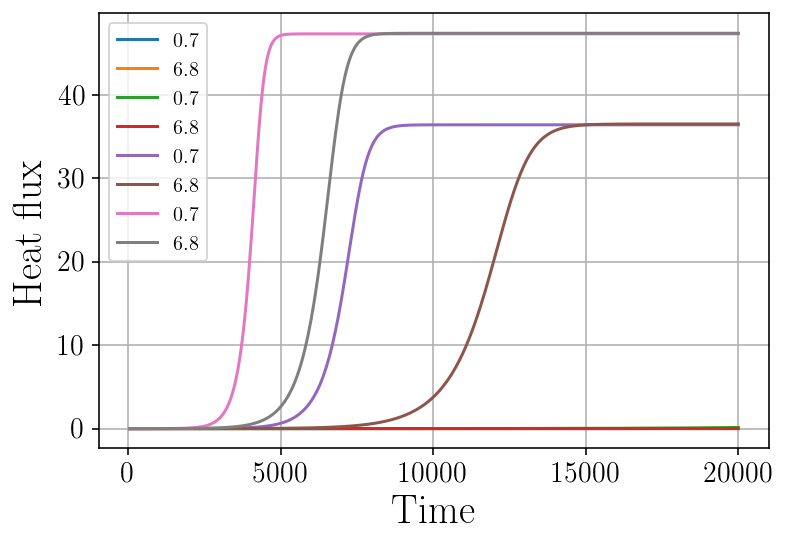

In [5]:
plt.plot(tau.T, CQ.T)
plt.legend(Pr)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Heat flux')
plt.show()

# Dimensionalize time only

In [6]:
nsamples = 1  # Number of parameter values for each value of Ra

# Save actual dimensionless numbers for each parameter point as reference
Pr = []
Ra = []
kap = []
dT = []
alpha = []
g = []
nu = []
H = []

t = []
Q = []
dQ = []

for i in range(len(Ra_list)):
    for j in range(nsamples):
        Pr.append(Pr_list[i])
        Ra.append(Ra_list[i])
        kap.append(rng.uniform(0.5, 0.7))  # Thermal diffusivity (conductivity/rho*Cp)
        dT.append(rng.uniform(50, 80))     # Temperature difference
        alpha.append(rng.uniform(1e-4, 5e-4))
        g.append(9.8)
        nu.append(kap[-1]*Pr[-1])
        H.append(np.sqrt(nu[-1]*kap[-1]*Ra[-1]/(g[-1]*alpha[-1]*dT[-1])))
        
        # To dimensionalize
        t.append(np.sqrt(H[-1]/(g[-1]*alpha[-1]*dT[-1]))*tau_list[i])
#         Q.append(kap[-1]*dT[-1]*CQ_list[i])
#         dQ.append(np.gradient(Q[-1], t[-1][1]-t[-1][0]))
        
        # Nondimensional quantities and time
        Q.append(CQ_list[i])
        dQ.append(np.gradient(Q[-1], t[-1][1]-t[-1][0]))
        

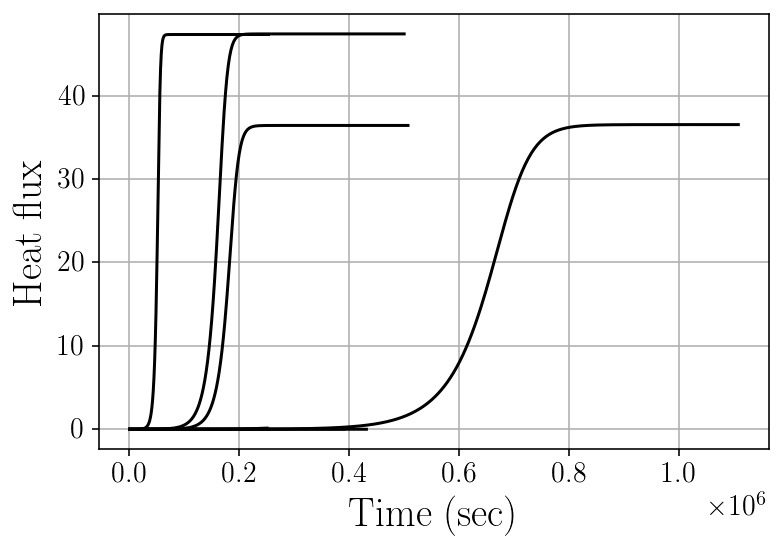

In [7]:
for i in range(len(Q)):
    plt.plot(t[i], Q[i], c='k')
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Heat flux')
plt.show()

In [8]:
# Dimension matrix: [length, temperature, time] x [H, g, alpha, dT, nu, kap]
D = np.array([[1, 0, 0], [1, 0, -2], [1, -1, 0], [0, 1, 0], [2, 0, -1], [2, 0, -1]]).T

time_vec = np.array([0, 0, 1])
# All 
nondim_list, timescale_list = get_nondim_numbers(D, 2, D.shape[1], time_vec=time_vec)

# Parameter matrix
stretch = lambda p_list: np.hstack([np.full(len(t), p) for (t, p) in zip(t, p_list)])
P = np.vstack([ stretch(p) for p in (H, g, alpha, dT, nu, kap) ]).T

p_sym = sym.symbols(r'H, g, \alpha, dT, \nu, \kappa')

In [10]:
# Define candidate functions
q_fns = [lambda q: q[0],
         lambda q: q[0]**3,
        ]

p_fns = [lambda pi: 1+0*pi[0],
         lambda pi: pi[0]]


def Theta(Q, Pi):
    return np.vstack(
    [
        [
            q_fns[m](Q)*p_fns[n](Pi) for m in range(len(q_fns))
        ]
        for n in range(len(p_fns))  # Loops over this first, so first M functions are g[0]
    ]).T

In [11]:
def fit_all_dynamics(opt, nondim_list, timescale_list, num_nondim, verbose=False):
    from IPython.display import display, Math
    
    input_combinations = list(combinations(nondim_list, num_nondim))
    loss_list = []
    param_list = []
    param_names = []
    
    for T_vec in timescale_list:
        Pi_t = np.exp( np.log(P) @ T_vec ).T  # Timescale
        
        # Quantity of interest scaled by time
        y = np.hstack(Q)[None, :]
        dy = (Pi_t*np.hstack(dQ))[None, :]
        w = Pi_t*stretch([max(abs(dy)) for dy in dQ])  # Weight by maximum LHS
        
        for pi_vecs in input_combinations:
            # Compute dimensionless parameters
            Pi = np.exp( np.log(P) @ np.vstack(pi_vecs).T ).T

            # Fit SINDy model
            lib = Theta(y, Pi)
            opt.fit(lib, dy.T, row_weights=w)
            Xi = opt.coef_.T
            test_loss = linalg.norm(dy.T - lib @ Xi) / linalg.norm(dy.T)

            # Save results
            loss_list.append(test_loss)

            # Save this parameter combination
            test_params = [sym.prod(p_sym**T_vec)]
            test_params.append([sym.prod(p_sym**pi_vec) for pi_vec in pi_vecs])
            param_names.append(test_params)
            param_list.append( (T_vec, pi_vecs) )
            if verbose:
                display(Math(sym.latex(test_params)))
                print('test loss = ', test_loss)
                print('----------------------------')
    return param_list, param_names, loss_list

In [12]:
num_nondim=1
opt = STLSQ(threshold=1e-10, cond=None, max_iter=5, normalize=True)
param_list, param_names, loss_list = fit_all_dynamics(opt, nondim_list, timescale_list, num_nondim, verbose=False)

In [13]:
from IPython.display import display, Math
sort_idx = np.argsort(loss_list)

for i in range(5):
    display(Math(sym.latex(param_names[sort_idx[i]])), Math)
    print('test loss = ', loss_list[sort_idx[i]])
    print('----------------------------')

<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.06875757789240337
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.06882514336433837
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.06925552192502814
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.12453326690364275
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.1296280849673698
----------------------------


In [14]:
model_idx = 0
T_vec = param_list[sort_idx[model_idx]][0]
pi_vec = param_list[sort_idx[model_idx]][1]

Pi_t = np.exp( np.log(P) @ T_vec ).T  # Timescale

# Compute dimensionless parameters
Pi_q = np.exp( np.log(P) @ np.vstack(pi_vec).T ).T

# Quantity of interest scaled by time
y = np.hstack(Q)[None, :]
dy = (Pi_t*np.hstack(dQ))[None, :]

# Fit SINDy model
lib = Theta(y, Pi_q)
opt.fit(lib, dy.T)
Xi = opt.coef_[0, :]
Xi

array([-7.50063002e-03,  2.90707675e-06,  3.78427616e-06, -1.47908029e-09])

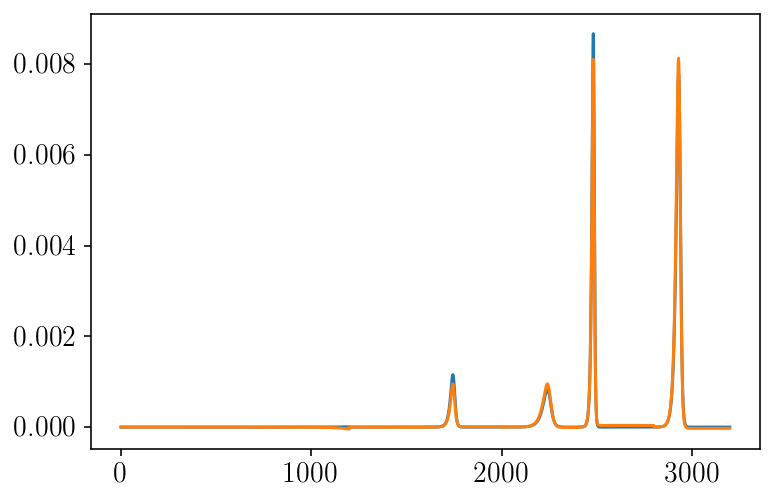

In [15]:
plt.plot(dy.T)
plt.plot(lib @ Xi)

In [16]:
lib = Theta(sym.symbols('q,'), sym.symbols('\pi_1,')).flatten('F')
model = lib @ Xi
model

-1.47908028946956e-9*\pi_1*q**3 + 3.78427615902042e-6*\pi_1*q + 2.90707674720693e-6*q**3 - 0.00750063002348222*q

### Test evaluation

In [35]:
idx = 0
q0 = [abs( Q[idx][0] )]
p_vec = np.array([H[idx], g[idx], alpha[idx], dT[idx], nu[idx], kap[idx]])
Pi_q = np.exp( np.log(p_vec) @ np.vstack(pi_vec).T ).T
Pi_t = np.exp( np.log(p_vec) @ T_vec ).T  # Timescale

lib = Theta(sym.symbols('q,'), Pi_q).flatten('F')
model = ( lib @ Xi ) / Pi_t
model

1.4077666013634e-7*q**3 - 0.000396293040293113*q

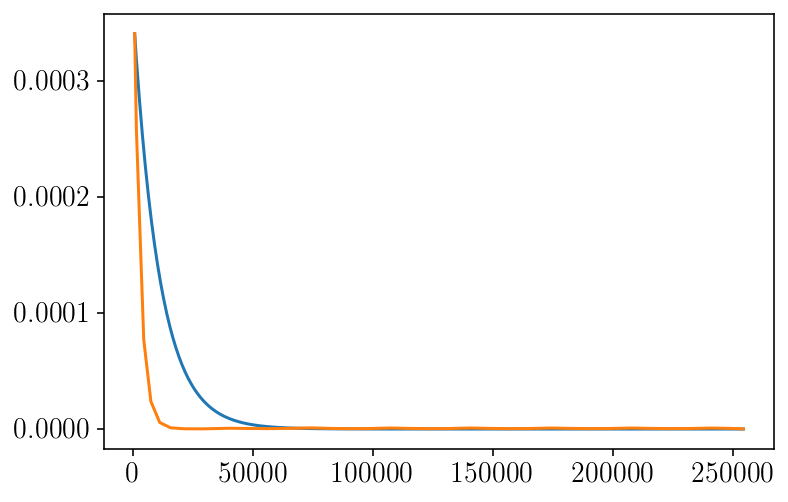

In [31]:
rhs = lambda t, q: (Theta([q], Pi_q).flatten('F') @ Xi) / Pi_t
t_span = (t[idx][0], t[idx][-1])
sol = solve_ivp(rhs, t_span, q0)

plt.plot(t[idx], Q[idx])
plt.plot(sol.t, sol.y.T)

# Find fixed points (bifurcation diagram)

In [37]:
from scipy.optimize import root

n_plt = 100
Ra_plt = np.linspace(1800, 2100, n_plt)
eq_plt = np.zeros(n_plt)
x0 = 40
for i in range(n_plt):
    Pi_q = [Ra_plt[-(1+i)]]
    rhs = lambda q: (Theta([q], Pi_q).flatten('F') @ Xi)
    sol = root(rhs, x0=x0)
    eq_plt[-(1+i)] = sol.x
    x0 = sol.x

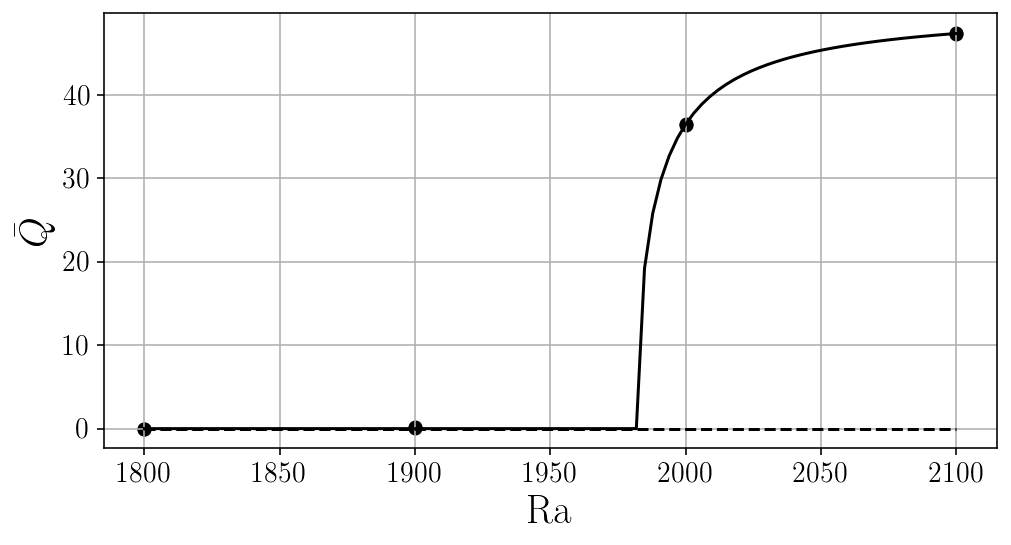

In [49]:
eq_sim = [Q[-1] for Q in CQ_list]

plt.figure(figsize=(8, 4))
plt.plot(Ra_plt, eq_plt, c='k')
plt.plot(Ra_plt, 0*eq_plt, c='k', ls='--')
plt.scatter(Ra_list, eq_sim, c='k')
plt.grid()
plt.xlabel("Ra")
plt.ylabel(r"$\bar{Q}$")
plt.show()